# Notebook Feux Danois

Dans cette partie nous éudierons un jeu de données correspondant aux feux de forets Danois entre 1980 et 1990

In [49]:
rm(list = ls())   # erase everything, start from scratch!
library(evir)
library(lubridate)
data(danish)
library(qualityTools)
library(dplyr)
library(ggplot2)

#??date
# summary(danish)
#danish



Attaching package: ‘ggplot2’


The following object is masked from ‘package:evir’:

    qplot




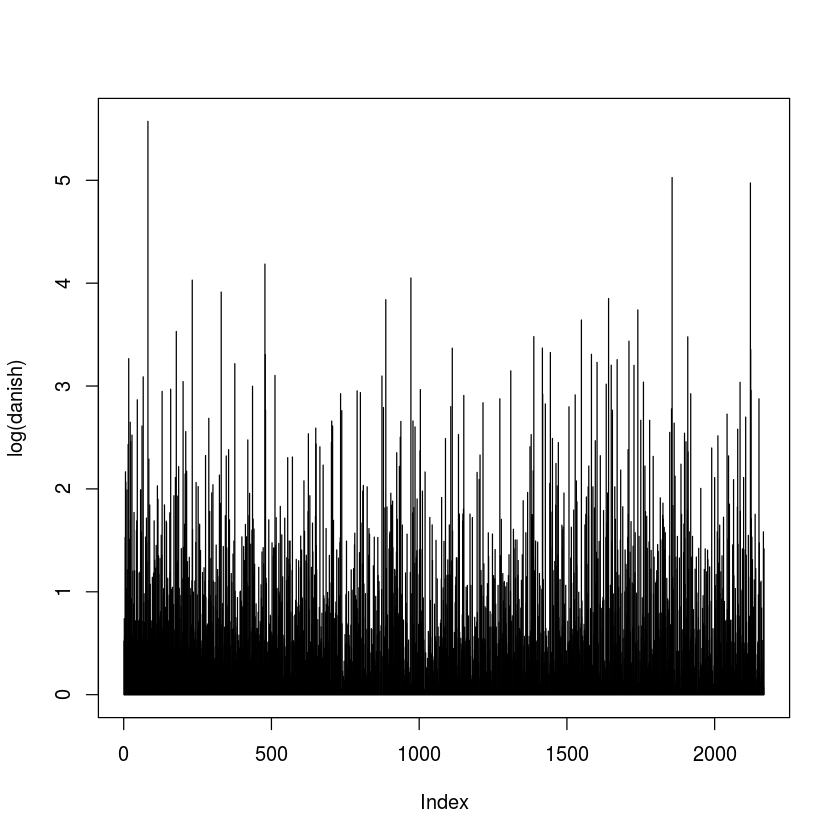

In [51]:
plot(log(danish),type ="h")

In [52]:
temps=attributes(danish)$times
df= data.frame (danish)
time.interval <- temps[0:2166] %--% temps[2 :  2167]

time.duration <- as.duration(time.interval)
Time= as.numeric (time.duration, "days")


In [53]:
N_T= cumsum(Time)
Lamb=length(N_T)/N_T[length(N_T)]
print (Lamb)

[1] 0.539477


Construction du dataframe pour travailler sur les données

In [54]:
df$T_i <- c(0,N_T)
df$W_i <- c(Time,0)
df$Year <- substring(temps,1,4)
head(df)

,danish,T_i,W_i,Year
,<dbl>,<dbl>,<dbl>,<chr>
1,1.683748,0,1,1980
2,2.093704,1,1,1980
3,1.732581,2,2,1980
4,1.779754,4,0,1980
5,4.612006,4,3,1980
6,8.725274,7,0,1980


In [55]:
df_annee <- df%>%
group_by(Year)%>%
summarise(Moyenne_Feux = mean(W_i),
         Lambda_Est = 1/mean(W_i),
         Nombre_Feux = n())


Si on suppose que le processus de comptage suit le processus de Poisson, lambda estimé par 0.5.
On a à peu près 1 claim tous les deux jours.

On veut s'assurer que ce processus suive bien une loi de Poisson. Il faut que les Wi soient des exponentielles iid de param (1/lmbda). Or on s'appersoit que le paramètre lambda ne semble pas être constant sur les 11 années !



In [56]:
df_annee

Year,Moyenne_Feux,Lambda_Est,Nombre_Feux
<chr>,<dbl>,<dbl>,<int>
1980,2.192771,0.4560440,166
1981,2.176471,0.4594595,170
1982,2.000000,0.5000000,181
1983,2.372549,0.4214876,153
1984,2.245399,0.4453552,163
1985,1.768116,0.5655738,207
1986,1.529412,0.6538462,238
1987,1.615044,0.6191781,226
1988,1.747619,0.5722071,210


Pour la suite et afin d'approximer au mieux un processus de poisson homogène nous décidons de travailler sur les 5 premières années ! 

In [57]:
d_homo <- df[which(df$Year < 1986),]
dh_annee <- df%>%
group_by(Year)%>%
summarise(Moyenne_Feux = mean(W_i),
         Lambda_Est = 1/mean(W_i),
         Nombre_Feux = n())
dh_annee

Year,Moyenne_Feux,Lambda_Est,Nombre_Feux
<chr>,<dbl>,<dbl>,<int>
1980,2.192771,0.4560440,166
1981,2.176471,0.4594595,170
1982,2.000000,0.5000000,181
1983,2.372549,0.4214876,153
1984,2.245399,0.4453552,163
1985,1.768116,0.5655738,207
1986,1.529412,0.6538462,238
1987,1.615044,0.6191781,226
1988,1.747619,0.5722071,210


A présent nous estimons notre nouveau paramètre $\hat{\lambda}$:

In [58]:
N_T_H= cumsum(d_homo$W_i)
Lamb_h=length(N_T_H)/N_T[length(N_T_H)]
print (Lamb_h)

[1] 0.4746691


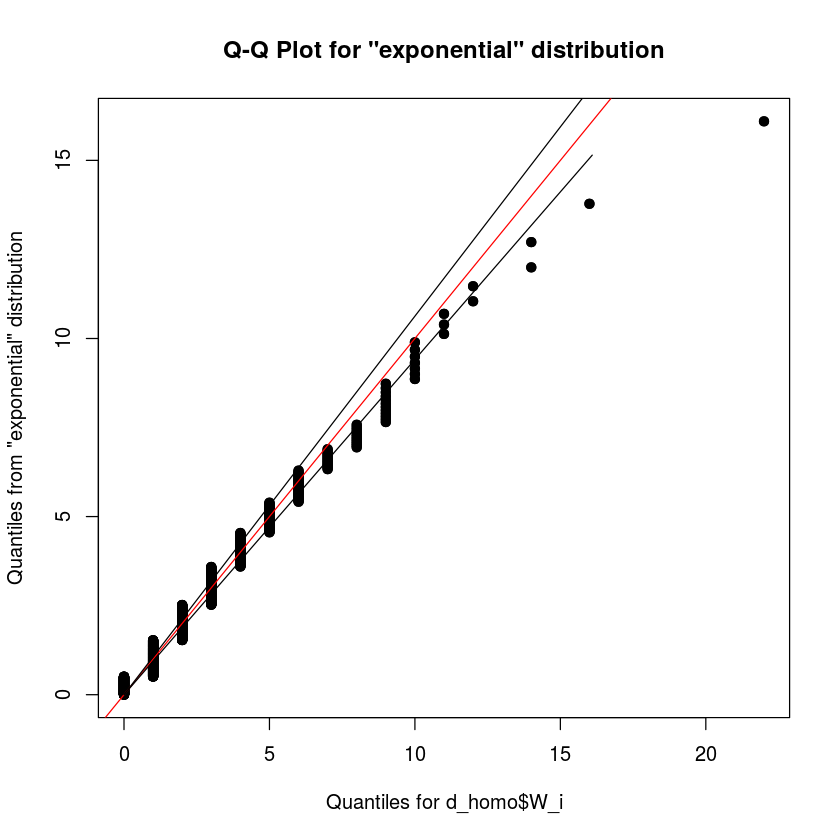

In [59]:
qqPlot(x = d_homo$W_i, y ="exponential")

In [63]:
library(stats)
library(qqplotr)


Attaching package: ‘qqplotr’


The following objects are masked from ‘package:ggplot2’:

    stat_qq_line, StatQqLine




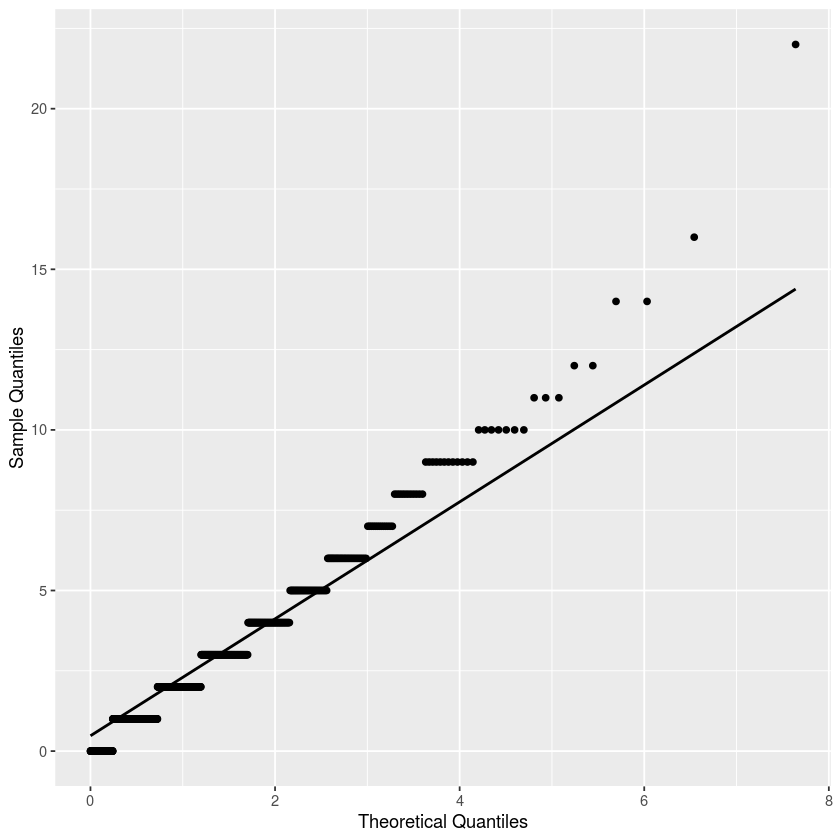

In [73]:
di <- "exp" # exponential distribution
dp <- list(rate = 1) # exponential rate parameter

gg <- ggplot(data = d_homo, mapping = aes(sample = W_i)) +
    stat_qq_line(distribution = di, dparams = dp) +
    stat_qq_point(distribution = di, dparams = dp) +
    labs(x = "Theoretical Quantiles", y = "Sample Quantiles")
gg

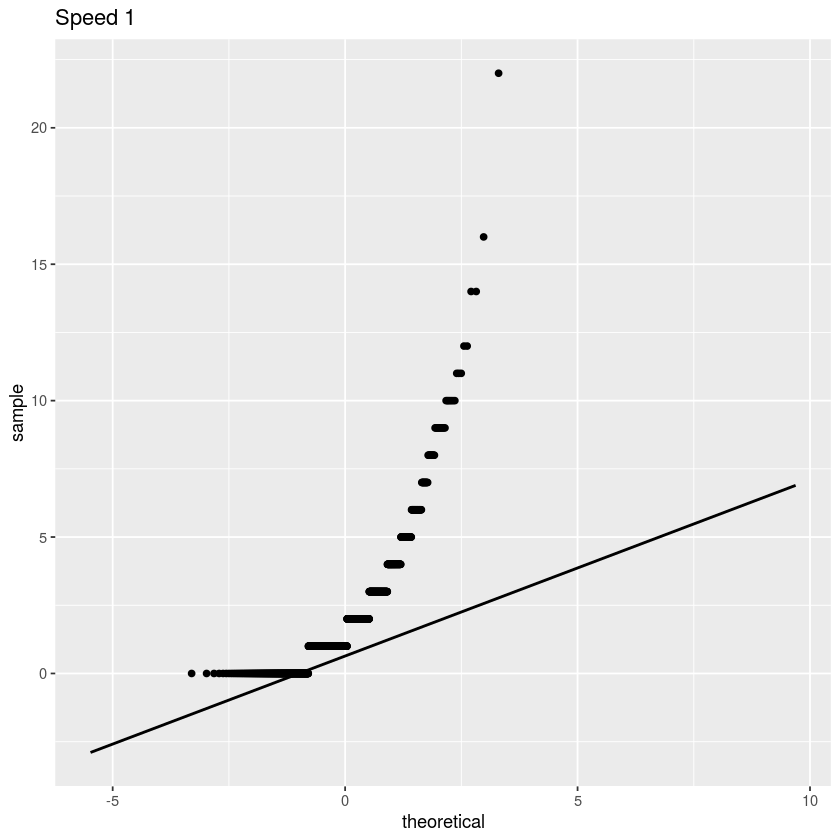

In [84]:
p1 = ggplot(d_homo, aes(sample = W_i))+
  stat_qq() + 
  stat_qq_line()+
  ggtitle("Speed 1")
p1

### Test sur la loi des W_t : sur tout le jeux de données

In [9]:
#Code pas très optimal mais permets de créer des Wt ou il n'y a plus de zéro

N=length (Time)
Time2=Time
for (i in (2:N-1)){
      if (Time[i]==0 & Time [i+1]!=0 )
      {Time2[i]=0.5} 
    else if (Time[i]==0 & Time [i+1]==0 )
    {Time2[i]=0.3
        Time2[i+1]=0.3}  
}

In [10]:
# Les test avec Time 2: Ks test ne change pas LcKs un peu meilleur mais reste petit (0.001)
library(KScorrect)

ks.test(Time2,"pexp")

Lc <- LcKS(Time2,cdf="pexp",nreps=999)
Lc$p.value

Warning message in ks.test(Time2, "pexp"):
"ties should not be present for the Kolmogorov-Smirnov test"



	One-sample Kolmogorov-Smirnov test

data:  Time2
D = 0.39112, p-value < 2.2e-16
alternative hypothesis: two-sided


[1] 0.001

In [9]:
mu1= mean (Time) #pour s'assurer qu'on retrouve bien Lamb=1/mu1

ks.test(Time,"pexp",1/mu1)
#ks.exp.test(Time)#,"pexp",lambda=1/mu1)

Warning message in ks.test(Time, "pexp", 1/mu1):
“ties should not be present for the Kolmogorov-Smirnov test”



	One-sample Kolmogorov-Smirnov test

data:  Time
D = 0.241, p-value < 2.2e-16
alternative hypothesis: two-sided


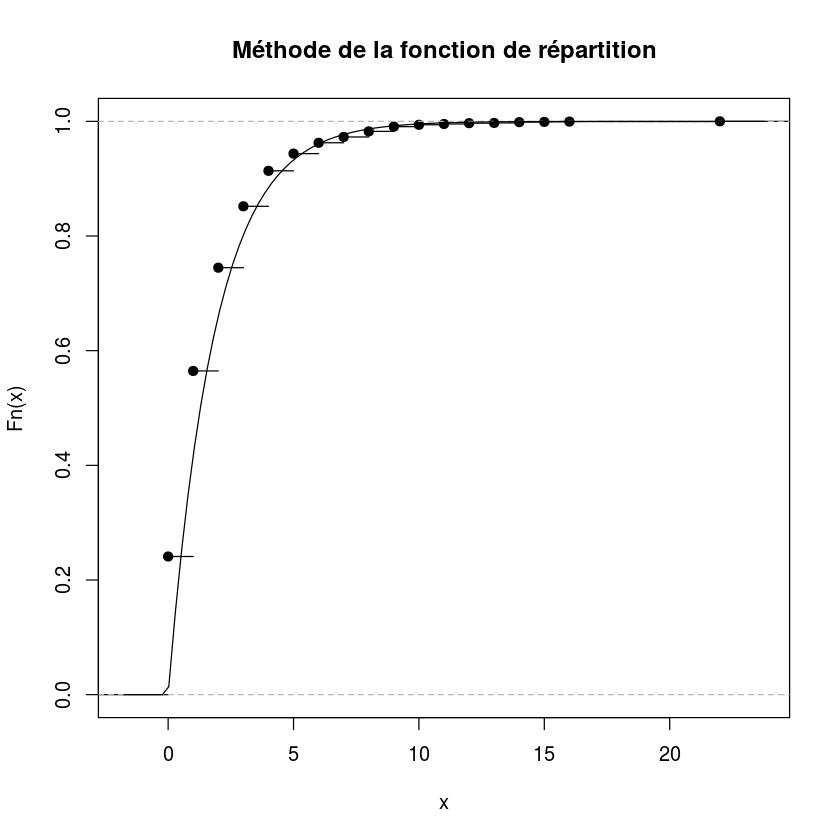

In [10]:
###  Methode en affichant la fdr empirique

plot(ecdf(Time), main = "Méthode de la fonction de répartition")
curve(pexp(x, 1/mu1), add = TRUE)


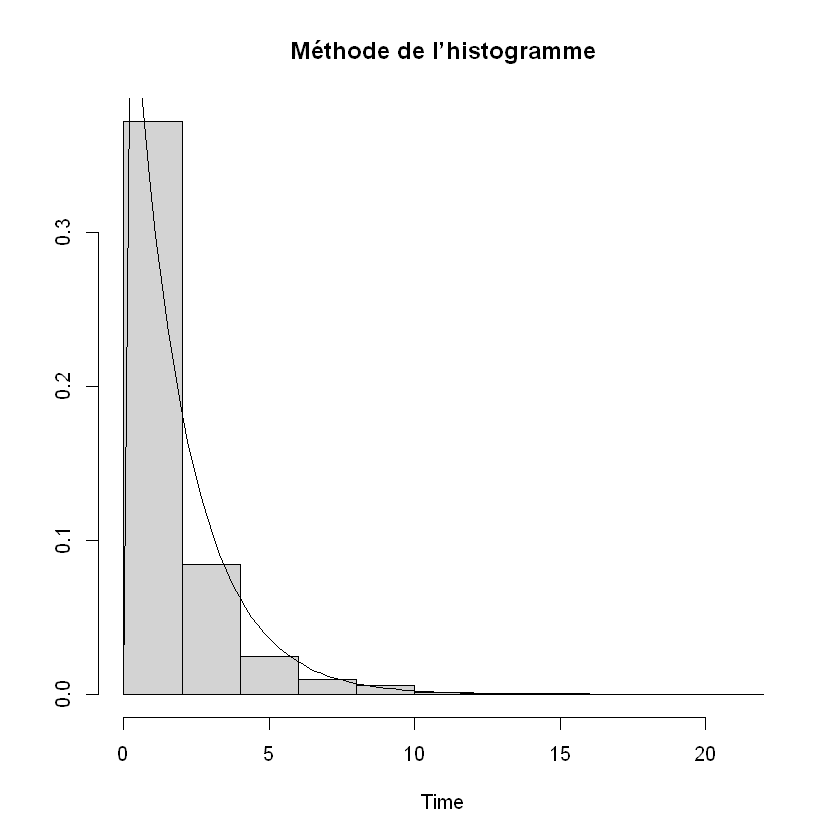

In [6]:
###  Version en affichant les histogrammes empirique
hist(Time, freq = FALSE, main = "Méthode de l’histogramme", ylab = "")
curve(dexp(x, 1/mu1), add = TRUE)

On analyse le processus de poisson associé aux données Danish Fire afin de s'assurer que notre processus est homogène !

Sous les hyothèses que les que $W_i$ sont iid et suivent un processus $Exp(\lambda)$ nous pouvons estimer $\widehat{\lambda}=0.54$

On est dans le cas Large claims, on commence par observer les données et estimer lambda

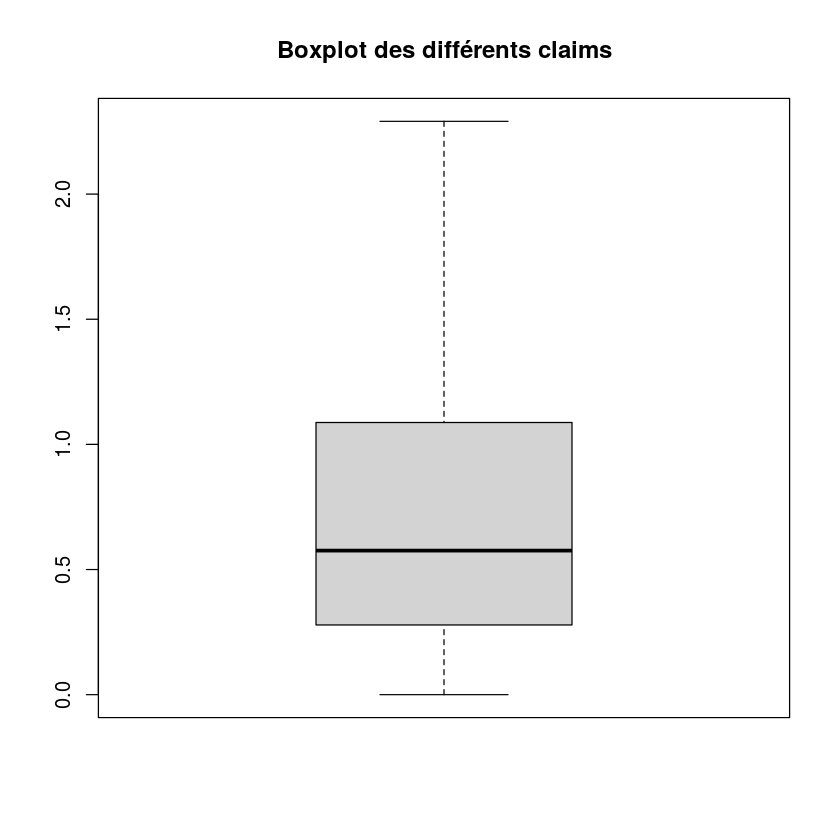

In [3]:
boxplot(log(danish),main="Boxplot des différents claims",outline=FALSE) #j'applique le log sur les claims
#Calcul de la moyenne et ecart type de X
mu=mean(danish)
sigma= sd(danish)


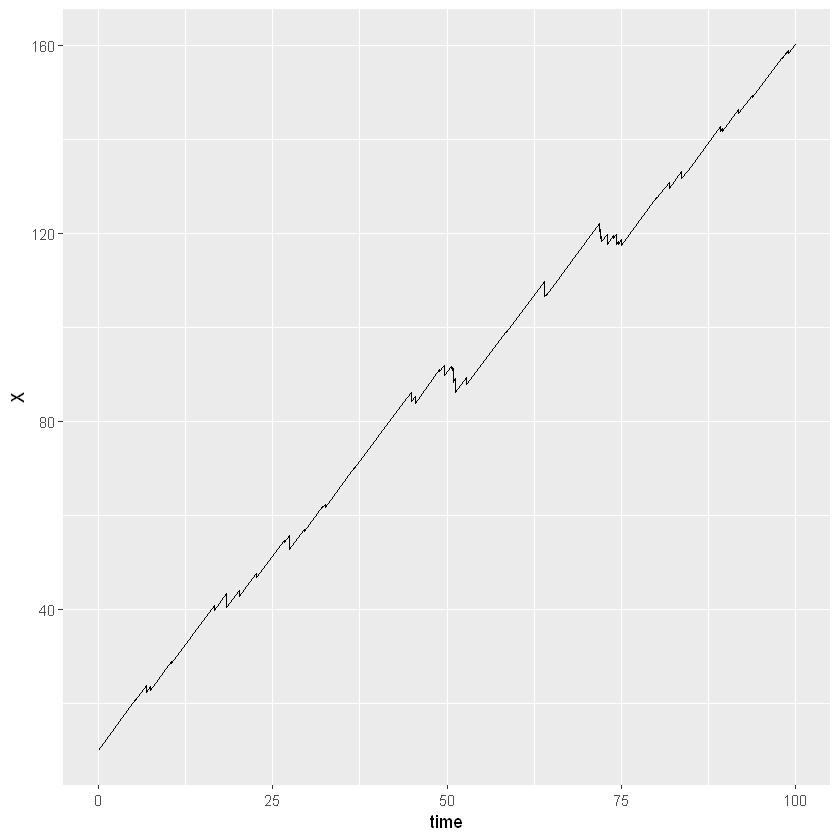

In [16]:
###  Il y'a possibilté de génerer directement le modèle CL avec le packge ruin
library(ruin)


model <- CramerLundberg(initial_capital = 10,
premium_rate = 2,
claim_poisson_arrival_rate = Lamb,
claim_size_generator = rexp,
claim_size_parameters = list(rate = 1))
path <- simulate_path(model = model, max_time_horizon = 100)
plot_path(path)